In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from normalize_data import getNormalizedDataset
import category_encoders as ce

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from category_encoders import OneHotEncoder, BinaryEncoder, CountEncoder, CatBoostEncoder

cat_features = ['tipodepropiedad', 'ciudad', 'provincia']

# Métrica de evaluación
def RMSLE(actual, pred):
    actualLog = np.log(actual + 1)
    predLog = np.log(pred + 1)
    return (np.mean((actualLog - predLog) ** 2)) **.5


def target_encoding(df_norm, mode, enc=None):
    '''enc debe ser None si se llama con mode='train', Target Encoder si se llama con mode='test''''
    if mode=='train':
        enc = ce.TargetEncoder(cols=cat_features).fit(df_norm.drop('precio', axis=1), df_norm['precio'])
        df_final = enc.transform(df_norm.drop('precio', axis=1), df_norm['precio'])
    if mode=='test':
        df_final = enc.transform(df_norm)
        
    return df_final, enc


def label_encoding(df_norm, mode, enc=None):
    if mode=='train':
        encoder = LabelEncoder()
        encoded = df_norm[cat_features].apply(encoder.fit_transform)
        df_2 = df_norm.drop(['tipodepropiedad','provincia','ciudad'], axis=1)
        data_cols = list(df_2.columns)
        baseline_data = df_2[data_cols].join(encoded)
    if mode=='test':
        new_cats = enc.transform(df_norm[cat_features])
        baseline_data = df_norm.drop(['tipodepropiedad','ciudad','provincia'], axis=1).join(new_cats)
        
    return baseline_data, encoder

def one_hot_enc(df_norm):
    one_hot_enc = OneHotEncoder()
    one_hot_encoded = one_hot_enc.fit_transform(df_norm[cat_features])
    data = df_norm.join(one_hot_encoded.add_suffix("_oh"))
    return data, one_hot_enc

def binary_enc(df_norm):
    binary_enc = BinaryEncoder()
    binary_encoded = binary_enc.fit_transform(df_norm[cat_features])
    data = df_norm.join(binary_encoded.add_suffix("_binary"))
    data = data.drop(['tipodepropiedad','provincia','ciudad'], axis=1)
    return data, binary_enc

def count_enc(df_norm, mode, count_enc=None):
    if mode=='train':
        count_enc = CountEncoder()
        count_encoded = count_enc.fit_transform(df_norm[cat_features])
        data = df_norm.join(count_encoded.add_suffix("_count"))
        data = data.drop(['tipodepropiedad','provincia','ciudad'], axis=1)
    if mode=='test':
        new_cats = count_enc.transform(df_norm[cat_features])
        baseline_data = df_norm.drop(['tipodepropiedad','ciudad','provincia'], axis=1).join(new_cats)
    return data, count_enc


def catboost_enc(df_norm):
    catboost_enc = CatBoostEncoder(cols=cat_features)
    catboost_enc.fit(df_norm[cat_features], df_norm['precio'])
    data = df_norm.join(catboost_enc.transform(df_norm[cat_features]).add_suffix('_cb'))
    data = data.drop(['tipodepropiedad','provincia','ciudad'], axis=1)
    return data, catboost_enc

In [29]:
df = pd.read_csv('train.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])

df_test = pd.read_csv('test.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])

import warnings
warnings.filterwarnings('ignore')

In [4]:
#normalizo la data, borrando los reg malos y llenando nulos
df_norm = getNormalizedDataset(df)

/home/ggparente95/.local/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ggparente95/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ggparente95/Gaston/facultad/Facu/Organizacion de Datos/tp2/tp2-zonajobs/normalize_data.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [ ]:
df_numeric, enc = target_encoding(df_norm, 'train')
X = df_numeric.copy()
y = df_numeric['precio']

# Tuning de hiperparametros

In [9]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
# A ver que hiperparametros uso el random forest de recien
print('Parameters currently in use:\n')
#pprint(regressor.get_params())

Parameters currently in use:



In [10]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Seteo una grid de parametros con valores aleatorios para utilizar

# Numero de arboles en el random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Numero de features por cada split
max_features = ['auto', 'sqrt']

# Maximo numero de profundidad (niveles del arbol)
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimo numero de samples por cda ssplit
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 2,
                               cv = 2,
                               verbose=2,
                               n_jobs = 2,
                               pre_dispatch = 2)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

# Gridsearch con cv

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 2, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

# Buscando los mejores test size y los mejores encodings

## Analizando test sizes

In [103]:
df_normalized = getNormalizedDataset(df)

In [116]:
# Test sizes with target encoding
df_final, target_enc = target_encoding(df_normalized, 'train')

X = df_final.copy()
y = df_norm['precio']
scores = []

for ts in [0.25,0.27,0.29,0.31,0.33]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts)
    regressor = RandomForestRegressor() 
    regressor.fit(X_train, y_train)  
    pred_1 = regressor.predict(X_test)
    score_1 = RMSLE(y_test, pred_1)
    scores.append(('Target Encoding',ts,score_1))

scores

[('Target Encoding', 0.25, 0.34657823914781816),
 ('Target Encoding', 0.27, 0.3457577202302427),
 ('Target Encoding', 0.29, 0.3450077790270425),
 ('Target Encoding', 0.31, 0.3492302954420671),
 ('Target Encoding', 0.33, 0.34639206170995646)]

In [117]:
# Test sizes with label encoding
df_final, label_enc = label_encoding(df_normalized)

X = df_final.copy()
y = df_final['precio']


for ts in [0.25,0.27,0.29,0.31,0.33]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts)
    regressor = RandomForestRegressor() 
    regressor.fit(X_train, y_train)  
    pred_1 = regressor.predict(X_test)
    score_1 = RMSLE(y_test, pred_1)
    scores.append(('Label Encoding', ts, score_1))

scores

[('Target Encoding', 0.25, 0.34657823914781816),
 ('Target Encoding', 0.27, 0.3457577202302427),
 ('Target Encoding', 0.29, 0.3450077790270425),
 ('Target Encoding', 0.31, 0.3492302954420671),
 ('Target Encoding', 0.33, 0.34639206170995646),
 ('Label Encoding', 0.25, 7.961281549638962e-05),
 ('Label Encoding', 0.27, 8.573901003574048e-05),
 ('Label Encoding', 0.29, 8.381669350941999e-05),
 ('Label Encoding', 0.31, 8.699899189065048e-05),
 ('Label Encoding', 0.33, 8.67651452717075e-05)]

In [119]:
# Test sizes with one hot encoding
df_final, count_enc = count_enc(df_normalized)

X = df_final.copy()
y = df_final['precio']


for ts in [0.25,0.27,0.29,0.31,0.33]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts)
    regressor = RandomForestRegressor() 
    regressor.fit(X_train, y_train)  
    pred_1 = regressor.predict(X_test)
    score_1 = RMSLE(y_test, pred_1)
    scores.append(('Count Encoding', ts, score_1))

scores

[('Target Encoding', 0.25, 0.34657823914781816),
 ('Target Encoding', 0.27, 0.3457577202302427),
 ('Target Encoding', 0.29, 0.3450077790270425),
 ('Target Encoding', 0.31, 0.3492302954420671),
 ('Target Encoding', 0.33, 0.34639206170995646),
 ('Label Encoding', 0.25, 7.961281549638962e-05),
 ('Label Encoding', 0.27, 8.573901003574048e-05),
 ('Label Encoding', 0.29, 8.381669350941999e-05),
 ('Label Encoding', 0.31, 8.699899189065048e-05),
 ('Label Encoding', 0.33, 8.67651452717075e-05),
 ('Count Encoding', 0.25, 7.698476019897642e-05),
 ('Count Encoding', 0.27, 8.019311773556814e-05),
 ('Count Encoding', 0.29, 8.322476497896979e-05),
 ('Count Encoding', 0.31, 8.237713042077031e-05),
 ('Count Encoding', 0.33, 8.618444513539426e-05)]

In [120]:
# Test sizes with one hot encoding
df_final, binary_enc = binary_enc(df_normalized)

X = df_final.copy()
y = df_final['precio']

for ts in [0.25,0.27,0.29,0.31,0.33]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts)
    regressor = RandomForestRegressor() 
    regressor.fit(X_train, y_train)  
    pred_1 = regressor.predict(X_test)
    score_1 = RMSLE(y_test, pred_1)
    scores.append(('Binary Encoding', ts, score_1))

scores

[('Target Encoding', 0.25, 0.34657823914781816),
 ('Target Encoding', 0.27, 0.3457577202302427),
 ('Target Encoding', 0.29, 0.3450077790270425),
 ('Target Encoding', 0.31, 0.3492302954420671),
 ('Target Encoding', 0.33, 0.34639206170995646),
 ('Label Encoding', 0.25, 7.961281549638962e-05),
 ('Label Encoding', 0.27, 8.573901003574048e-05),
 ('Label Encoding', 0.29, 8.381669350941999e-05),
 ('Label Encoding', 0.31, 8.699899189065048e-05),
 ('Label Encoding', 0.33, 8.67651452717075e-05),
 ('Count Encoding', 0.25, 7.698476019897642e-05),
 ('Count Encoding', 0.27, 8.019311773556814e-05),
 ('Count Encoding', 0.29, 8.322476497896979e-05),
 ('Count Encoding', 0.31, 8.237713042077031e-05),
 ('Count Encoding', 0.33, 8.618444513539426e-05),
 ('Binary Encoding', 0.25, 7.726434415460663e-05),
 ('Binary Encoding', 0.27, 8.111288833301922e-05),
 ('Binary Encoding', 0.29, 8.333417145593777e-05),
 ('Binary Encoding', 0.31, 8.960809792646538e-05),
 ('Binary Encoding', 0.33, 8.832198295783028e-05)]

In [121]:
# Test sizes with one hot encoding
df_final, catboost_enc = catboost_enc(df_normalized)

X = df_final.copy()
y = df_final['precio']

for ts in [0.25,0.27,0.29,0.31,0.33]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts)
    regressor = RandomForestRegressor() 
    regressor.fit(X_train, y_train)  
    pred_1 = regressor.predict(X_test)
    score_1 = RMSLE(y_test, pred_1)
    scores.append(('Catboost', ts, score_1))

scores

[('Target Encoding', 0.25, 0.34657823914781816),
 ('Target Encoding', 0.27, 0.3457577202302427),
 ('Target Encoding', 0.29, 0.3450077790270425),
 ('Target Encoding', 0.31, 0.3492302954420671),
 ('Target Encoding', 0.33, 0.34639206170995646),
 ('Label Encoding', 0.25, 7.961281549638962e-05),
 ('Label Encoding', 0.27, 8.573901003574048e-05),
 ('Label Encoding', 0.29, 8.381669350941999e-05),
 ('Label Encoding', 0.31, 8.699899189065048e-05),
 ('Label Encoding', 0.33, 8.67651452717075e-05),
 ('Count Encoding', 0.25, 7.698476019897642e-05),
 ('Count Encoding', 0.27, 8.019311773556814e-05),
 ('Count Encoding', 0.29, 8.322476497896979e-05),
 ('Count Encoding', 0.31, 8.237713042077031e-05),
 ('Count Encoding', 0.33, 8.618444513539426e-05),
 ('Binary Encoding', 0.25, 7.726434415460663e-05),
 ('Binary Encoding', 0.27, 8.111288833301922e-05),
 ('Binary Encoding', 0.29, 8.333417145593777e-05),
 ('Binary Encoding', 0.31, 8.960809792646538e-05),
 ('Binary Encoding', 0.33, 8.832198295783028e-05),
 ('C

In [32]:
data = pd.DataFrame(scores, columns=['encoding','test_size','RMSLE'])
data.groupby(['encoding']).agg({'RMSLE':'mean'})

NameError: name 'scores' is not defined

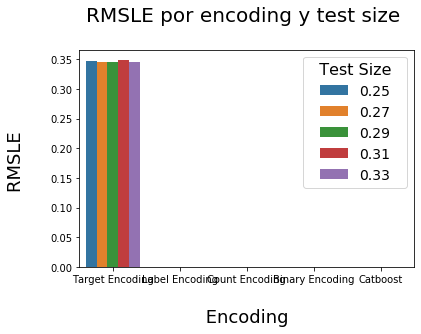

In [126]:
import seaborn as sns
ax = sns.barplot(data=data, x='encoding', y='RMSLE', hue='test_size')
ax.set_xlabel('\n Encoding ', fontsize=18)
ax.set_ylabel('RMSLE \n', fontsize=18)
ax.set_title('RMSLE por encoding y test size \n', fontdict={'fontsize':20})
plt.legend(title='  Test Size  ', title_fontsize=16, fontsize=14, loc='best')

In [127]:
df_norm.head()

,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,extras,dia,mes,anio
id,,,,,,,,,,,,,,,,,,,
254099,Apartamento,Benito Juárez,Distrito Federal,0,2,1,2,80,80,0,0,0,0,0,2273000.0,1.0,23,8,2015
53461,Casa en condominio,La Magdalena Contreras,Distrito Federal,10,3,2,2,268,268,0,0,0,1,1,3600000.0,2.0,28,6,2013
247984,Casa,Tonalá,Jalisco,5,3,2,2,144,166,0,0,0,0,0,1200000.0,2.0,17,10,2015
209067,Casa,Zinacantepec,Edo. de México,1,2,1,1,63,67,0,0,0,1,1,650000.0,1.0,9,3,2012
185997,Apartamento,Zapopan,Jalisco,10,2,1,1,95,95,0,0,0,0,0,1150000.0,1.0,7,6,2016


# RF CON OTRO ENCODING Y HIPERPARAMETROS TUNEADOS

In [11]:
df_norm = getNormalizedDataset(df)
df_train, target_enc = target_encoding(df_norm)
X = df_train
y = df_norm['precio']

rf = RandomForestRegressor(n_estimators=544, min_samples_split=10, min_samples_leaf=4,\
                           max_features='sqrt', max_depth=None, bootstrap= False)

rf.fit(X,y)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=544,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [30]:
df_test_norm = getNormalizedDataset(df_test, 'test')
new_cats = count_enc.transform(df_test_norm[cat_features])
X_test = df_test_norm.drop(['tipodepropiedad','ciudad','provincia'], axis=1).join(new_cats)
# Todos aquellos que sean de una categoria que yo no tenia en el set de datos, lo mando a una nueva.
X_test.ciudad.fillna(X_test.ciudad.value_counts().idxmax(), inplace=True)
X_test.ciudad.fillna(X_test.provincia.value_counts().idxmax(), inplace=True)
X_test.ciudad.fillna(X_test.tipodepropiedad.value_counts().idxmax(), inplace=True)

pred = rf.predict(X_test)


In [31]:
res = pd.DataFrame(pred, index=df_test.index, columns=['target'])
display(res.head())
res.to_csv("submission.csv", header=True) # RMSLE=0.65487

,target
id,
4941,5.293697e+06
51775,9.105863e+05
115253,2.570804e+06
299321,1.522730e+06
173570,5.714495e+05


In [28]:
X_test

,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,extras,dia,mes,anio
id,,,,,,,,,,,,,,,,,,
4941,2.208718e+06,3.955634e+06,3.083064e+06,29,3,0,4,300,300,0,0,0,0,0,0.0,20,7,2013
51775,2.661225e+06,2.004539e+06,2.003991e+06,0,1,1,1,67,67,0,0,0,0,0,1.0,24,10,2015
115253,2.661225e+06,2.857428e+06,3.083064e+06,0,2,1,2,87,100,0,0,0,0,1,1.0,30,5,2015
299321,2.661225e+06,2.562207e+06,2.518969e+06,2,2,2,2,86,86,0,0,0,0,0,2.0,2,4,2015
173570,2.208718e+06,8.848046e+05,2.604062e+06,10,2,1,1,80,80,0,0,0,1,1,1.0,15,8,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75094,2.208718e+06,1.798636e+06,3.083064e+06,20,4,3,3,291,291,0,0,0,1,1,3.0,19,9,2015
171847,2.208718e+06,1.074004e+06,2.604062e+06,10,3,1,2,71,87,0,0,0,1,1,1.0,19,10,2016
138313,2.208718e+06,1.455254e+06,2.453852e+06,5,3,2,2,102,102,0,0,0,1,1,2.0,2,12,2014
